In [1]:
import sys
sys.path.append("/home/diego/Dropbox/hold_noise/iclamp-glm/")

In [2]:
import numpy as np
from icglm.iclamp import IClamp
ic = IClamp.load_from_abf(path='./18o03049.abf')
ic = ic.subtract_Ih(th=1000.1).restrict(t0=1000.1, tf=11000.1)
ic.plot(sweeps=[0])

(<Figure size 1200x500 with 2 Axes>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x7efda2b84278>,
  <matplotlib.axes._subplots.AxesSubplot at 0x7efda2b4c898>))

(<Figure size 648x288 with 2 Axes>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x7efd6825acc0>,
  <matplotlib.axes._subplots.AxesSubplot at 0x7efd67968128>))

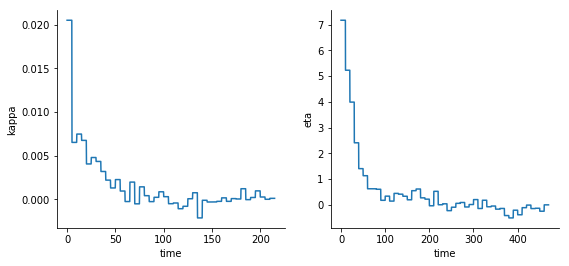

In [3]:
from icglm.glm_fitting import GLMFitter
glm_fit = GLMFitter(ic).set_mask_spikes(thr=-13).subsample(10)

tbins_kappa = np.arange(0, 220, 5)
tbins_eta = np.arange(0, 480, 10)

glm_fit.fit(tbins_kappa=tbins_kappa, tbins_eta=tbins_eta)
glm_fit.plot_filters()

(<Figure size 864x504 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7efd678e29e8>,
       dtype=object))

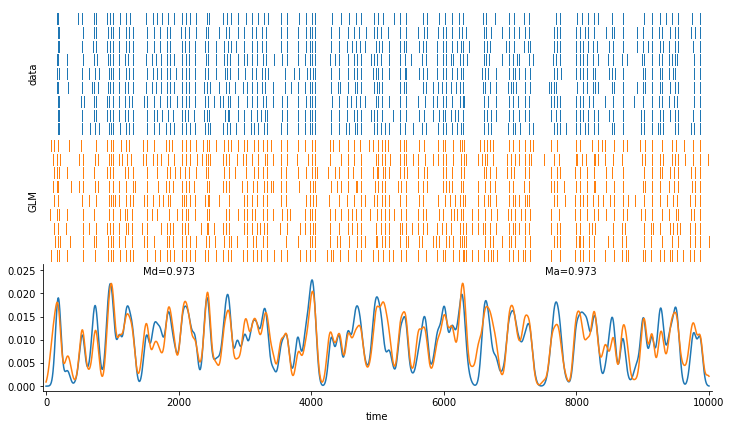

In [4]:
from icglm.kernels import KernelFun
glm_fit.set_mask_spikes_model(trials=9)
glm_fit.psth(psth_kernel=KernelFun.gaussian_delta(delta=40))
glm_fit.plot_raster()

In [5]:
from icglm.glm_decoding import GLMDecoder
Imu, Isd = np.mean(glm_fit.ic.stim), np.mean(np.std(glm_fit.ic.stim, 0))

I0 = np.zeros(len(glm_fit.ic.t))
decoder = GLMDecoder(glms=[glm_fit.glm], t=glm_fit.ic.t, mask_spk=[glm_fit.mask_spikes], 
                     tau=3, Imu=[Imu], Isd=[Isd], I_true=(glm_fit.ic.stim - Imu) / Isd)

decoder.estimate_MAP_I(I0, prior='OU', verbose=True)

Starting decoding... 

 Finished at 19 of 100 iterations Elapsed time: 17.01 seconds